In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [4]:
# https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip

In [5]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [6]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

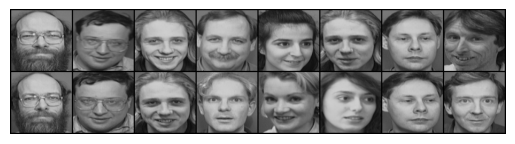

[0. 0. 0. 1. 1. 1. 0. 1.]


In [7]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [8]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [9]:
def convert_to_grayscale_pixel_by_pixel(image_path):
    image = Image.open(image_path).convert('RGB') 
    image_data = np.array(image)  
    gray_values = np.mean(image_data, axis=-1, keepdims=True) 
    grayscale_image = np.repeat(gray_values, 3, axis=-1)  
    grayscale_image_pil = Image.fromarray(grayscale_image.astype(np.uint8))
    return grayscale_image_pil

In [10]:
import matplotlib.image as mpimg
import numpy as np

def rgb_to_gray(img_path):
    img = mpimg.imread(img_path)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray_image = Image.fromarray(gray.astype(np.uint8))  
    return gray_image

In [11]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [12]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=64)

In [13]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.184115171432495

Epoch number 1
 Current loss 1.0953541994094849

Epoch number 2
 Current loss 0.8475170135498047

Epoch number 3
 Current loss 1.1969634294509888

Epoch number 4
 Current loss 0.6386776566505432

Epoch number 5
 Current loss 0.7884429097175598

Epoch number 6
 Current loss 0.5726569890975952

Epoch number 7
 Current loss 0.7083317637443542

Epoch number 8
 Current loss 0.5881576538085938

Epoch number 9
 Current loss 0.5928367972373962

Epoch number 10
 Current loss 0.5088028907775879

Epoch number 11
 Current loss 0.45694586634635925

Epoch number 12
 Current loss 0.5749444961547852

Epoch number 13
 Current loss 0.29133111238479614

Epoch number 14
 Current loss 0.4053640365600586

Epoch number 15
 Current loss 0.4972602427005768

Epoch number 16
 Current loss 0.7597355842590332

Epoch number 17
 Current loss 0.4828322231769562

Epoch number 18
 Current loss 0.39984598755836487

Epoch number 19
 Current loss 0.4406580924987793

Epoch nu

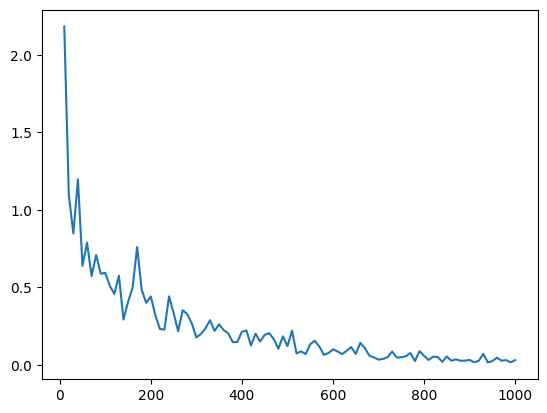

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        # img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())


torch.save(net.state_dict(), 'siamese__model.pth')
print("Model saved as 'siamese__model.pth'.")

show_plot(counter, loss_history)

In [76]:
def rgb_to_grayscale(image):
    # Convert to grayscale manually by averaging the R, G, B channels
    grayscale_image = image.convert('RGB')  # Convert to RGB to access R, G, B channels
    grayscale_data = torch.tensor(grayscale_image)  # Convert image to tensor
    # Average the RGB channels for grayscale
    grayscale_data = grayscale_data.mean(dim=-1, keepdim=True) / 255.0  # Normalize to [0, 1]
    return grayscale_data

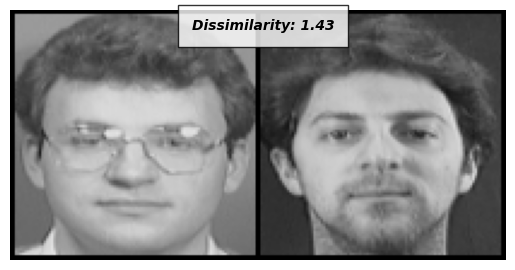

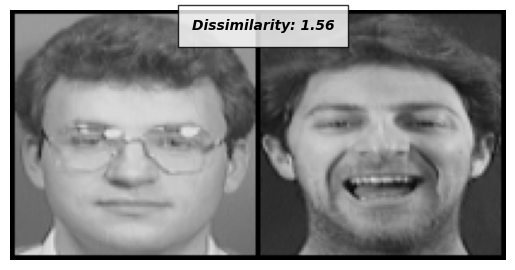

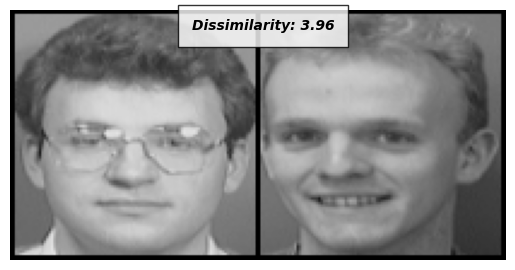

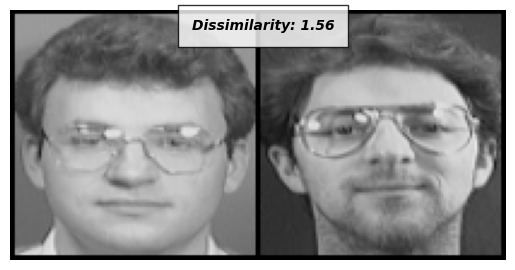

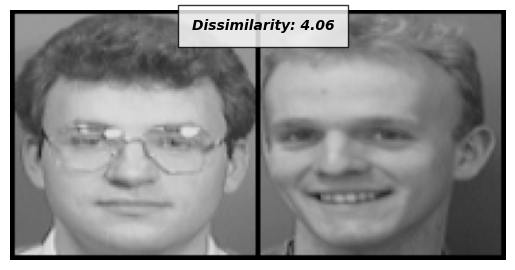

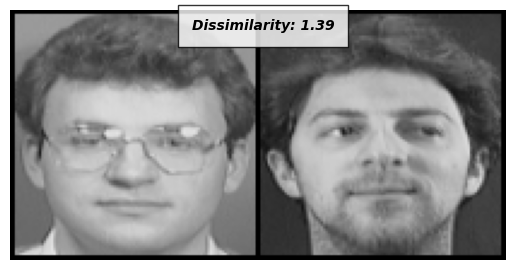

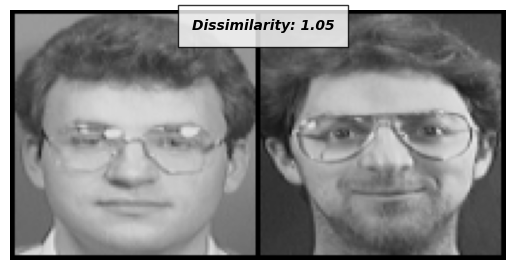

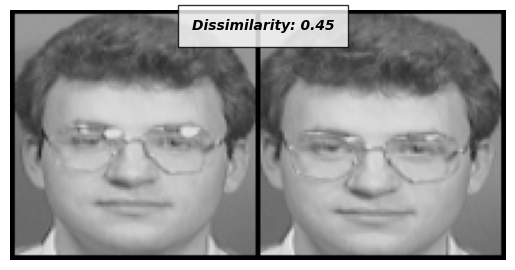

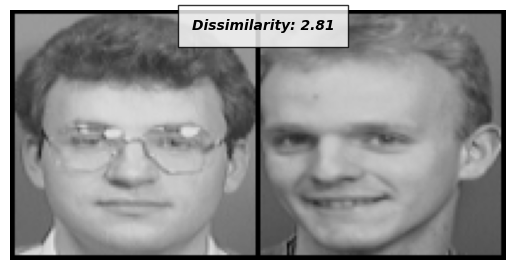

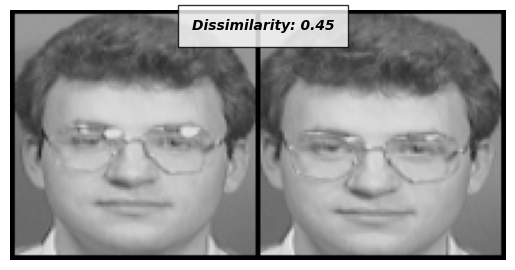

In [16]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)


for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [20]:

images = os.listdir('./data/positive')
images

['39308b65-baf1-11ef-8e53-b025aa50b1a8.jpg',
 '36d81292-baf1-11ef-9958-b025aa50b1a8.jpg',
 '3faeb6e0-baf1-11ef-8c3b-b025aa50b1a8.jpg',
 '39a7b7e6-baf1-11ef-b726-b025aa50b1a8.jpg',
 '3fc35af2-baf1-11ef-9827-b025aa50b1a8.jpg',
 '3ad3532f-baf1-11ef-9c86-b025aa50b1a8.jpg',
 '3d4c533d-baf1-11ef-8c72-b025aa50b1a8.jpg',
 '3e4783d4-baf1-11ef-887f-b025aa50b1a8.jpg',
 '374f5aed-baf1-11ef-a04a-b025aa50b1a8.jpg',
 '375bf37a-baf1-11ef-8f78-b025aa50b1a8.jpg',
 '3b6132fc-baf1-11ef-815a-b025aa50b1a8.jpg',
 '3d639223-baf1-11ef-bd89-b025aa50b1a8.jpg',
 '3d9e003f-baf1-11ef-a252-b025aa50b1a8.jpg',
 '39db3cf9-baf1-11ef-9a6e-b025aa50b1a8.jpg',
 '3a135e55-baf1-11ef-ac77-b025aa50b1a8.jpg',
 '3c11fb81-baf1-11ef-96d0-b025aa50b1a8.jpg',
 '391f11e1-baf1-11ef-9b0d-b025aa50b1a8.jpg',
 '3bf62579-baf1-11ef-adfa-b025aa50b1a8.jpg',
 '36b6b9cc-baf1-11ef-8d0a-b025aa50b1a8.jpg',
 '36b6d015-baf1-11ef-9bf8-b025aa50b1a8.jpg',
 '0811a0da-ba55-11ef-9274-b025aa50b1a8.jpg',
 '3fe746ea-baf1-11ef-8af6-b025aa50b1a8.jpg',
 '3c5d5896

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.94509804].


Dissimilarity: 0.78
True


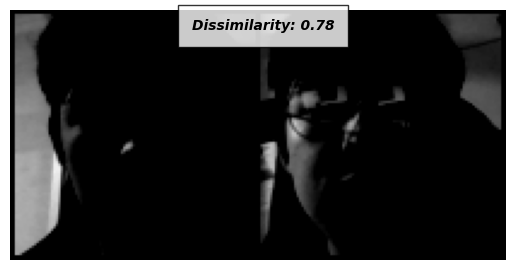

In [48]:
import torch
from PIL import Image, ImageEnhance
from torchvision import transforms
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import os

# Ensure you have the same transformations applied as in the dataset
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Adjust based on the input size of your model
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Adjust if necessary
])

# Load two images from the folder

images = os.listdir('./data/positive')

# image_path_1 = os.path.join('./data/positive', images[0])  
# image_path_2 = os.path.join('./data/positive', images[1])

image_path_1 = './application_data/test/sanjar3.jpg'
image_path_2 = './application_data/test/sanjar6.jpg'


image1 = Image.open(image_path_1).convert('L')
image2 = Image.open(image_path_2).convert('L')

# Apply the transformations
image1_transformed = transform(image1).unsqueeze(0)  # Add batch dimension
image2_transformed = transform(image2).unsqueeze(0)  # Add batch dimension


# imshow(image1_transformed[0], f"Transformed Image 1")
# imshow(image2_transformed[0], f"Transformed Image 2")

# Ensure the model is in evaluation mode
net.eval()

# Pass the two images through the model
output1, output2 = net(image1_transformed, image2_transformed)

# Calculate the Euclidean distance between the two outputs
euclidean_distance = F.pairwise_distance(output1, output2)

# Concatenate images for visualization
concatenated = torch.cat((image1_transformed, image2_transformed), 0)

print(f'Dissimilarity: {euclidean_distance.item():.2f}')

if euclidean_distance.item() <= 1.0:
    print(True)
else:
    print(False)

imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [40]:
import cv2 

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    key = cv2.waitKey(10) & 0xFF
    if key == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        # results, verified = verify(siamese_model, 0.5, 0.5)
        # print(verified)
    
    if key == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()